This notebook contains python codes to run strontium isotope box model

In [1]:
# import python module
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

In [16]:
# Functions
# ---------
def simNSr(jr, jh, jcarb):
    """
    Strontium Mass Balance

    Parameters
    ----------
    jr : float
        Global riverine flux of Sr
    jh : float
        Hydrothermal flux of Sr.
    jcarb : float
        strontium uptake during carbonate deposition
    
    Returns
    -------
    nsr : float
        Seawater Sr reservoir size in mol
    """
    nsr = jr + jh - jcarb
    return nsr

# Isotopic mass balace equation
def simSr(jr, rr, rsw, jh, rh, n):
    """

    Strontium isotopic mass balance.

    Parameters
    ----------
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSr : float
        Strontium isotopic ratio of seawater.

    """
    rSr = (jr*(rr-rsw) + jh*(rh-rsw)) / n
    return rSr

# Function to run model
def run_sim(nt, dt, age, jr, rr, rsw, jh, rh, n):
    """
    
    Solving diff. equations defined in simSr() using the forward Euler method.

    Parameters
    ----------
    nt : int
        number of time steps to run model
    dt : float
        the size of each time step
    age : float
        age in million years
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSw : float
        Strontium isotopic ratio of seawater.
        
    """
    rsw0 = (jr[0]*rr[0] + jh[0]*rh[0])/(jr[0]+jh[0])
    rsw[0] = rsw0


    jcarb0 = jr[0] + jh[0]
    k = jcarb0 / n[0]
    jcarb = jcarb0
    
    for i in range(nt-1):
        n[i+1] = n[i] + simNSr(jr[i], jh[i], jcarb)*dt
        rsw[i+1] = rsw[i] + simSr(jr[i], rr[i], rsw[i], jh[i], rh[i], n[i])*dt
        jcarb = k * n[i]
    
   
    return rsw

### Define time
This block of code creates arrays to run the simulation.

In [3]:
# Define array of time
# --------------------
tmin = 487      # ~ base of Ordovician in Ma (GTS2020)
tmax = 443      # ~ base of Silurian in Ma (GST2020)
nt = 100000     # number of steps
dt = (tmin - tmax)*1e6 / nt    # size of each step
time = np.linspace(0, (tmin-tmax)*1e6, nt)    # time array
age = np.linspace(tmin, tmax, nt)             # age array (in Myr)

In [4]:
# Initial values and parameters
# -----------------------------
# Riverine flux (Jones and Jenkyns, 2001)
Jriv0 = 3.34e10
Jriv = np.ones(nt) * Jriv0

# Riverine isotopic ratio (Jones and Jenkyns, 2001)
Rriv0 = 0.7119
Rriv = np.ones(nt) * Rriv0

#Hydrothermal flux
Jh0 = 2e10
Jh = np.ones(nt)*1.05e10

# Hydrothermal isotopic ratio (Jones and Jenkyns, 2001)
Rh0 = 0.7033
Rh = np.ones(nt) * Rh0

# Array to store isotopic ratio of seawater
Rsw = np.zeros(nt)

# Reservoir size (Jones and Jenkyns, 2001)
N = np.ones(nt) * 1.24e17

### Constraining changes in hydrothermal activities using long-term sea-level change

In this model we hypothesize a role for hydrothermal activities in perturbing global Sr cycles during the Ordovician. To model changes in hydrothermal activities we used eustatic sea level curves, assuming the long-term changes in sea levels are mainly controlled by changes in ocean basin geometry, which in turn depends on the rate of sea floor spreading.

Sea level curves were taken from Haq and Schutter (2008), and recalibrated to Geologic Time Scale 2020 (Goldman et al., 2020).

In [5]:
# load sea level data
ordosealevel = np.load("../Data/OrdoSeaLevel.npz")['SeaLevel']
ordoseaage = np.load("../Data/OrdoSeaLevel.npz")['age']

array size = 100000


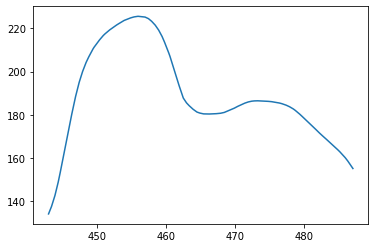

In [6]:
# resample data to fit our modeling array
from scipy import interpolate

f = interpolate.interp1d(ordoseaage, ordosealevel)

sealevel = f(age)
plt.plot(age, sealevel)
print('array size =',len(sealevel))

max  : 1.4536080670085052
min  : 0.8646907216494846
mean : 1.221990718759185


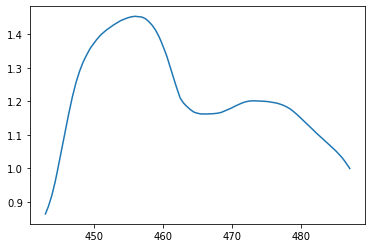

In [7]:
# normalize sea level relative to mean
sl_norm = sealevel / sealevel.mean()
sl_norm_min = sealevel / sealevel[0]

plt.plot(age, sl_norm_min)
print('max  :', sl_norm_min.max())
print('min  :', sl_norm_min.min())
print('mean :', sl_norm_min.mean())

In [8]:
Jh_sl = sl_norm * Jh0

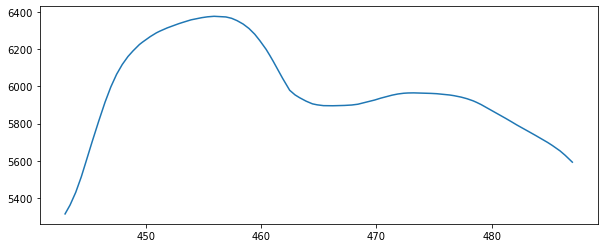

In [9]:
degass = (sl_norm)**0.35 * 6000
plt.figure(figsize=(10,4))
plt.plot(age, degass)

In [17]:
Rsw_sl = np.zeros(nt)
Rsw_sl = run_sim(nt, dt, age, Jriv, Rriv, Rsw_sl, Jh_sl, Rh, N)

In [11]:
output_model = {'age':age, 'Rsw':Rsw_sl}
pd.DataFrame(output_model).to_csv('../Output/SL_Model_output.csv', index=False)

# Final Figure

In [12]:
# Load Ordovician GTS2020
chronoDf = pd.read_excel('../Data/OrdoGTS2020.xlsx')
chronoDf.head(7)

,label,abbr,mix,top,bottom,color,h
0,Hirnantian,Hir.,Hir.,443.07,445.21,#A6DBAB,2.14
1,Katian,Kat.,Katian,445.21,452.75,#99D69F,7.54
2,Sandbian,Sand.,Sand.,452.75,458.18,#8CD094,5.43
3,Darriwillian,Darr.,Darriwillian,458.18,469.42,#74C69C,11.24
4,Dapingian,Dap.,Dap.,469.42,471.26,#66C092,1.84
5,Floian,Flo.,Flo.,471.26,477.08,#41B087,5.82
6,Tremadocian,Tre.,Tremadocian,477.08,486.85,#33A97E,9.77


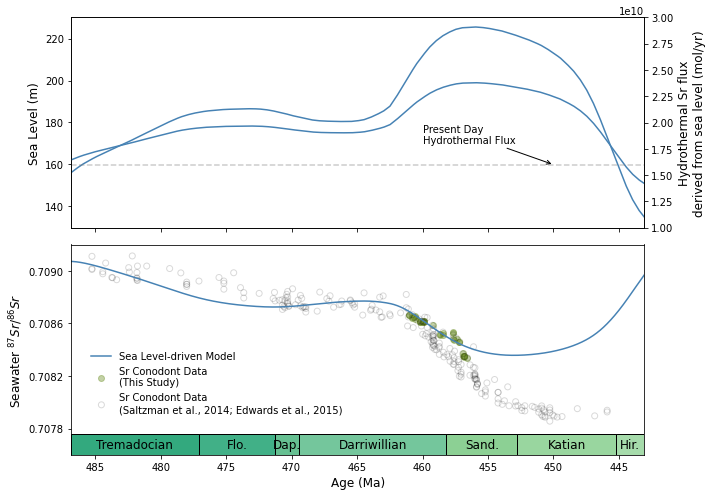

In [13]:
# Load sr measurement for comparison
SrOrdo = pd.read_csv('../Data/Arbuckle_Sr.csv')
loess = pd.read_csv('../Data/LOESS2_0.75_Gradient.csv')
SrOrdo_2014 = pd.read_excel('../Data/mastersr.xlsx')

#Make the Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7), sharex=True)

ax1.plot(age, sealevel,  c='steelblue', label='Sea Level')
ax1.set_ylabel("Sea Level (m)", fontsize=12)
ax1.invert_xaxis()

ax1b = ax1.twinx()
ax1b.set_ylim([1e10,3e10])
ax1b.plot(age, Jh_sl, c='steelblue')
ax1b.axhline(y=1.6e10, ls='--', c='gray', alpha=0.4)
ax1b.set_ylabel('Hydrothermal Sr flux\nderived from sea level (mol/yr)', fontsize=12)
ax1b.annotate('Present Day\nHydrothermal Flux', xy=(450, 1.6e10), xytext=(460, 1.8e10),
            arrowprops=dict(arrowstyle='->'))

trans = ax2.get_xaxis_transform()
ax2.plot(age, Rsw_sl, c='steelblue', label="Sea Level-driven Model")
ax2.scatter(SrOrdo['age'], SrOrdo['sr'], c='olivedrab', label='Sr Conodont Data\n(This Study)', alpha=0.4)
ax2.scatter(SrOrdo_2014['age'], SrOrdo_2014['sr'],
            ec='k', fc='None',
            label='Sr Conodont Data\n(Saltzman et al., 2014; Edwards et al., 2015)',
            alpha=0.15)
ax2.set_ylabel('Seawater $^{87}Sr/^{86}Sr$', fontsize=12)
ax2.set_xlabel('Age (Ma)', fontsize=12)
ax2.legend(loc='lower left', bbox_to_anchor=(0.02, 0.15), edgecolor='None')

for ind in chronoDf.index:
    ax2.add_patch(Rectangle(xy=[chronoDf['top'][ind], 0],
                           height=0.1,
                           width=chronoDf['h'][ind], transform = trans,
                           ec = 'black', fc = chronoDf['color'][ind]))
    ax2.text(chronoDf['top'][ind]+0.5*chronoDf['h'][ind], 0.05, str(chronoDf['mix'][ind]), rotation=0,
            horizontalalignment='center',
            verticalalignment='center', transform = trans, fontsize = 12)
    
ax2.set_xlim(486.85, 443.07)
ax2.set_ylim(0.7076, 0.7092)
ax2.set_yticks(np.linspace(0.7078, 0.7090, 4))

plt.tight_layout()
plt.savefig('../Figures/PaperFigure.png')
plt.savefig('../Figures/PaperFigure.svg')
plt.show()

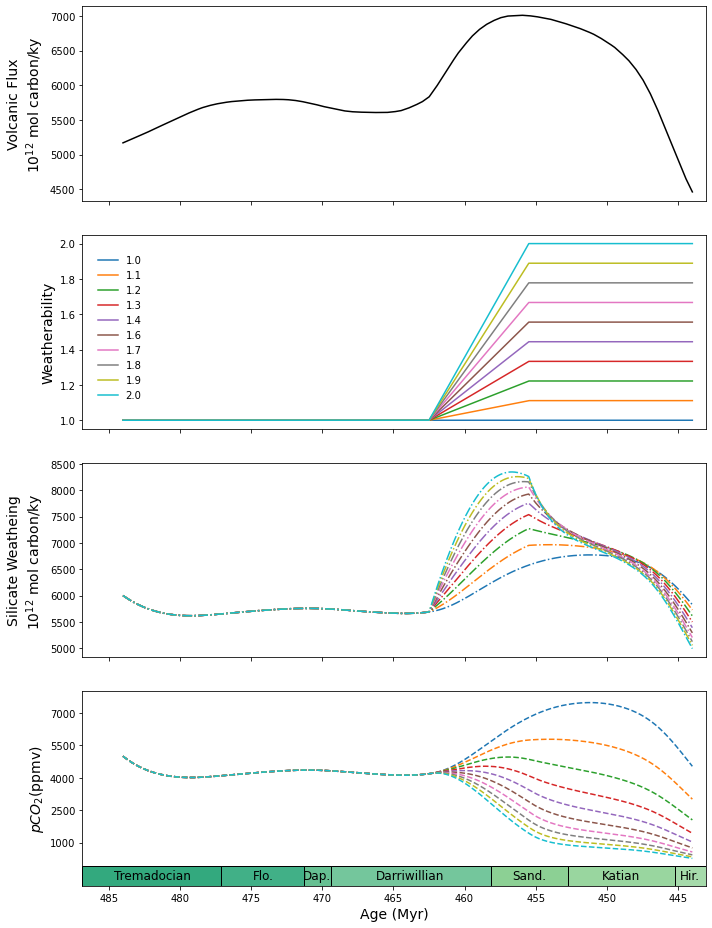

In [14]:
# Import python packages
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

## Phosphorus Cycle
def Mop(Fwp, Fbp):
    '''Mass of phosphate in the oceans
    Fwp : Flux of phosphate into the oceans
    Pbp : flux of phosphate out of the oceans due to burial
    '''
    y = (Fwp - Fbp)
    return y
def Fwp(weatherability, ClimateWeatheringFactor):
    '''
    Flux of phosphate to the oceans (10^12 mol per ky)
    '''
    y = 30 * weatherability * ClimateWeatheringFactor
    return y
def Fbp(Mop, Mop_initial):
    '''Burial of phosphate
    Mop : mass of phosphatein the ocean
    Mop_initial : initial Mop set to 3e3 x 10e12 mol/myr
    '''
    y = 30 * (Mop / Mop_initial)
    return y
def Moc(Fworg, Fvolc, Fborg, Fwsil):
    ''' Mass of Carbon in the atmosphere ocean system'''
    y = (Fworg + Fvolc - Fborg - Fwsil)
    return y

## Carbon Cycle
def Fworg(weatherability, ClimateWeatheringFactor):
    '''Weathering of organic matter'''
    y = 1e4 * weatherability * ClimateWeatheringFactor
    return y
def Fborg(Fbp, CtoP=333):
    '''Burial of organic matter
    Fbp : Flux of phosphate burial
    CtoP : Carbon to Phosphorus ratio (333)
    '''
    y = Fbp * CtoP
    return y
def Fwsil(weatherability, ClimateWeatheringFactor):
    '''Silicate weathering flux'''
    y = 6e3 * weatherability * ClimateWeatheringFactor
    return y

## Strontium Cycle
def Ro(ro, rb, rr, Fwsr, jhsl, Mosr):
    '''Isotopic mass balance of strontium'''
    y = (((1+ro)/(1+rb)) * (rr-ro) * Fwsr + ((1+ro)/(1+rb)) * (rb-ro) * jhsl) / (Mosr)
    return y
def Rr(time, weatherability):
    '''Sr ratios of riverine flux'''
    if time < 2e4:
        y = 0.7119 - time * 1e-8
    else:
        y = (0.7117 + (weatherability - 1) * 0.7033) / (weatherability)
    return y
def Fwsr(weatherability, climateweatheringfactor):
    '''Riverine Sr flux (continental)'''
    y = 30 * weatherability * climateweatheringfactor
    return y

## PCO2 and Climate Weathering Factor
def pCO2(Moc, Moc_0=1.61e7, pCO2_0=5000):
    '''Partial pressure of CO2'''
    y = (Moc / Moc_0)**2 * pCO2_0
    return y
def CWF(pCO2, pCO2_0=5000):
    '''Climate Weathering Factor'''
    y = (pCO2/pCO2_0)**0.3
    return y



def runmod(x):
    dt = 1
    # time
    time_min = 0
    time_max = 40000
    time = np.arange(time_min, time_max, dt)
    # array size
    t = len(time)
    age = 484 - time/1e3

    #set time and rate of weatherability change
    rise_start = np.where(np.round(age)==462)[0][0]     #statement looks up timestep closest to specified age, e.g. 463 Ma
    rise_stop = np.where(np.round(age)==455)[0][0]      #original Young model has rise start at 463, stop 459, fall 447, stop 443
    fall_start = np.where(np.round(age)==453)[0][0]
    # Weatherability
    W = np.ones(t)
    W[rise_start:rise_stop] = np.linspace(1.0, x, (rise_stop-rise_start))
    W[rise_stop:] = x

    # pCO2
    pco2= np.ones(t) # array for pCO2
    pco2_0 = 5000     # initial value of pCO2
    pco2[0] = pco2_0

    # Climate Weathering Factor (CWP)
    cwf = np.ones(t)
    cwf[0] = CWF(pco2[0])
    
    # load sea level data
    ordosealevel = np.load("../Data/OrdoSeaLevel.npz")['SeaLevel']
    ordoseaage = np.load("../Data/OrdoSeaLevel.npz")['age']

    # resample data to fit our modeling array
    from scipy import interpolate
    f = interpolate.interp1d(ordoseaage, ordosealevel)
    sealevel = f(age)

    # normalize sea level relative to mean
    sl_norm = sealevel / sealevel.mean()
    
    Jh_sl = sl_norm * 2e1
    
    # Initialize Fvolc; also tuning of volc flux
    fvolc = np.ones(t)
    fvolc = (sl_norm) * 6000 # initial value = 6000 (Kump and Arthur, 1999)
    
    #Initialize arrays for diff.eq #1
    mop = np.ones(t)  # array for Mop
    mop_0 = 3e3       # initial value of Mop
    mop[0] = mop_0    # assign initial value into array

    fwp = Fwp(W, cwf)     # initiate array for phosphorus flux
    fbp = Fbp(mop, mop_0) # initiate array for phosphorus burial

    # Initialize arrays for diff.eq #2
    moc = np.ones(t)  # array for Moc
    moc_0 = 1.61e7    # initial value of Moc
    moc[0] = moc_0    # assign initial value into array

    fworg = Fworg(W, cwf)
    fborg = Fborg(fbp)
    fwsil = Fwsil(W, cwf)
    
    # Initialize Mosr
    mosr = np.ones(t) * 12.4e4

    # Initialize arrays for diff.eq #3
    ro = np.ones(t)
    ro_0 = 0.7091
    ro[0] = ro_0

    rb = np.ones(t) * 0.7033
    fhyd = np.ones(t) * 1.75e-3

    rr = np.ones(t) * 0.7106
    rr[0] = Rr(time[0], W[0])

    fwsr = np.ones(t)
    fwsr[0] = Fwsr(W[0], cwf[0])
    
    # Model implementation
    for i in range(t-1):

        fworg[i+1] = Fworg(W[i], cwf[i])
        fborg[i+1] = Fborg(fbp[i])
        fwsil[i+1] = Fwsil(W[i], cwf[i])
        moc[i+1] = moc[i] + dt*Moc(fworg[i], fvolc[i], fborg[i], fwsil[i])

        pco2[i+1] = pCO2(moc[i], moc_0, pco2_0)
        cwf[i+1] = CWF(pco2[i])

        fwp[i+1] = Fwp(W[i], cwf[i])
        fbp[i+1] = Fbp(mop[i], mop_0)
        mop[i+1] = mop[i] + dt*Mop(fwp[i],fbp[i])

        rr[i+1] = Rr(time[i], W[i])
        fwsr[i+1] = Fwsr(W[i], cwf[i])
        ro[i+1] = ro[i] + dt*Ro(ro[i], rb[i], rr[i], fwsr[i], Jh_sl[i], mosr[i])
    
    results = {'age': age,
               'W': W,
               'fwsil' : fwsil,
               'pco2': pco2,
               'fvolc':fvolc,
               'fwsr':fwsr,
               'ro': ro}
    return results  

res = {}
ns = 10
weath = np.linspace(1, 2, ns)
for k in range(len(weath)):
    xx = str(int(k))
    res[xx] = runmod(weath[k])

# Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10,13))

SrOrdo = pd.read_csv('../Data/Arbuckle_Sr.csv')
SrOrdo_2014 = pd.read_csv('../Data/OrdoSr20.csv')

for key in res:
    ax2.plot(res[key]['age'], res[key]['W'], '-', label=str(round(res[key]['W'][-1],1)))
    #ax2.plot(res[key]['age'], res[key]['ro'], ls='--',label= 'Sr Isotope Model'+key)
    ax4.plot(res[key]['age'], res[key]['pco2'], '--', label= '$pCO_2$ Model'+key)
    
    ax3.plot(res[key]['age'], res[key]['fwsil'], '-.', label='Silicate Weathering Flux'+key)

ax1.plot(res['0']['age'], res[key]['fvolc'], 'k-')
# ax2.scatter(SrOrdo['age'], SrOrdo['sr'], c='olivedrab', label='Sr Conodont Data\n(This Study)', alpha=0.4)
# ax2.scatter(SrOrdo_2014['Age20'], SrOrdo_2014['Sr'],
#             ec='k', fc='None',
#             label='Sr Conodont Data\n(Saltzman et al., 2014)',
#             alpha=0.15)

ax2.set_ylabel('Weatherability', fontsize=14)
ax1.set_ylabel('Volcanic Flux\n$10^{12}$ mol carbon/ky', fontsize=14)
ax4.set_ylabel('$pCO_2$(ppmv)', fontsize=14)
ax3.set_ylabel('Silicate Weatheing\n$10^{12}$ mol carbon/ky', fontsize=14)

ax4.set_ylim(-1000, 8000)
ax4.set_yticks(np.linspace(1000, 7000, 5))

# for ax in (ax1,ax2, ax3, ax4):
#     ax.grid(True)

ax4.set_xlabel('Age (Myr)', fontsize=14)
ax4.set_xlim(486.85, 443.07)

ax2.legend(loc='lower left', bbox_to_anchor=(0.01, 0.1), edgecolor='None')
# ax2.legend(loc='lower left', bbox_to_anchor=(1.1, 0.5), edgecolor='None')
# ax3.legend(loc='lower left', bbox_to_anchor=(1.1, 0.1), edgecolor='None')
# ax4.legend(loc='lower left', bbox_to_anchor=( 1.1, 0.1), edgecolor='None')

# Load Ordovician GTS2020
chronoDf = pd.read_excel('../Data/OrdoGTS2020.xlsx')
trans = ax4.get_xaxis_transform()
for ind in chronoDf.index:
    ax4.add_patch(Rectangle(xy=[chronoDf['top'][ind], 0],
                           height=0.1,
                           width=chronoDf['h'][ind], transform = trans,
                           ec = 'black', fc = chronoDf['color'][ind], zorder=9))
    ax4.text(chronoDf['top'][ind]+0.5*chronoDf['h'][ind], 0.05, str(chronoDf['mix'][ind]), rotation=0,
            horizontalalignment='center',
            verticalalignment='center', transform = trans, fontsize = 12, zorder=9)

plt.tight_layout()
plt.savefig("../Figures/degassing_CO2_Sr_varyWeatherability_Final.png", dpi=300)
plt.savefig("../Figures/degassing_CO2_Sr_varyWeatherability_Final.svg")


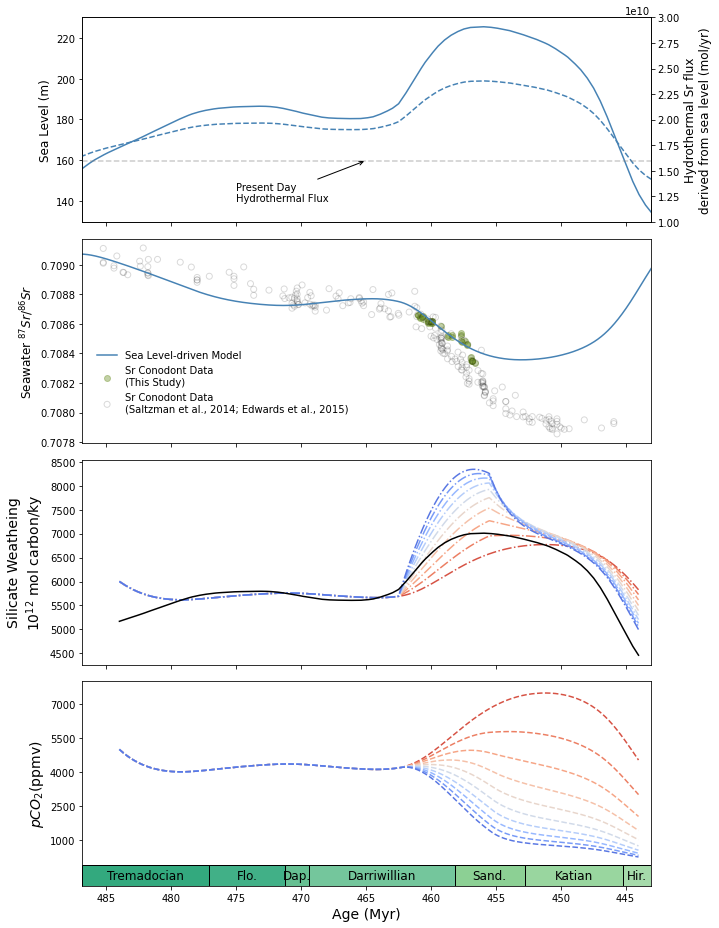

In [15]:
import matplotlib as mpl
from cycler import cycler

# Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10,13))

color = plt.cm.coolwarm_r(np.linspace(0.1,0.9,10))

ax3.set_prop_cycle(cycler('color', color))
ax4.set_prop_cycle(cycler('color', color))


SrOrdo = pd.read_csv('../Data/Arbuckle_Sr.csv')
SrOrdo_2014 = pd.read_excel('../Data/mastersr.xlsx')

for key in res:
    ax4.plot(res[key]['age'], res[key]['pco2'], '--', label= '$pCO_2$ Model'+key)
    ax3.plot(res[key]['age'], res[key]['fwsil'], '-.')

ax1.plot(age, sealevel,  c='steelblue', label='Sea Level')
ax1.set_ylabel("Sea Level (m)", fontsize=12)
ax1.invert_xaxis()

ax1b = ax1.twinx()
ax1b.set_ylim([1e10,3e10])
ax1b.plot(age, Jh_sl, ls='--',c='steelblue')
ax1b.axhline(y=1.6e10, ls='--', c='gray', alpha=0.4)
ax1b.set_ylabel('Hydrothermal Sr flux\nderived from sea level (mol/yr)', fontsize=12)
ax1b.annotate('Present Day\nHydrothermal Flux', xy=(465, 1.6e10), xytext=(475, 1.2e10),
            arrowprops=dict(arrowstyle='->'))

ax2.plot(age, Rsw_sl, c='steelblue', label="Sea Level-driven Model")
ax2.scatter(SrOrdo['age'], SrOrdo['sr'], c='olivedrab', label='Sr Conodont Data\n(This Study)', alpha=0.4)
ax2.scatter(SrOrdo_2014['age'], SrOrdo_2014['sr'],
            ec='k', fc='None',
            label='Sr Conodont Data\n(Saltzman et al., 2014; Edwards et al., 2015)',
            alpha=0.15)
ax2.set_ylabel('Seawater $^{87}Sr/^{86}Sr$', fontsize=12)
ax2.legend(loc='lower left', bbox_to_anchor=(0.02, 0.15), edgecolor='None')

ax3.plot(res['0']['age'], res[key]['fvolc'], 'k-')

ax4.set_ylabel('$pCO_2$(ppmv)', fontsize=14)
ax3.set_ylabel('Silicate Weatheing\n$10^{12}$ mol carbon/ky', fontsize=14)

ax4.set_ylim(-1000, 8000)
ax4.set_yticks(np.linspace(1000, 7000, 5))

# for ax in (ax1,ax2, ax3, ax4):
#     ax.grid(True)

ax4.set_xlabel('Age (Myr)', fontsize=14)
ax4.set_xlim(486.85, 443.07)

ax2.legend(loc='lower left', bbox_to_anchor=(0.01, 0.1), edgecolor='None')

# Load Ordovician GTS2020
chronoDf = pd.read_excel('../Data/OrdoGTS2020.xlsx')
trans = ax4.get_xaxis_transform()
for ind in chronoDf.index:
    ax4.add_patch(Rectangle(xy=[chronoDf['top'][ind], 0],
                           height=0.1,
                           width=chronoDf['h'][ind], transform = trans,
                           ec = 'black', fc = chronoDf['color'][ind], zorder=9))
    ax4.text(chronoDf['top'][ind]+0.5*chronoDf['h'][ind], 0.05, str(chronoDf['mix'][ind]), rotation=0,
            horizontalalignment='center',
            verticalalignment='center', transform = trans, fontsize = 12, zorder=9)

plt.tight_layout()
plt.savefig("../Figures/Figure6.png", dpi=300)
plt.savefig("../Figures/Figure6.svg")